# Open Interest Data

In [8]:
import os
import sys

import dotenv
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [9]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from client.query_api_client import QuantNoteQueryApi

## Create Query Api Client

In [10]:
dotenv.load_dotenv(".env")
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = QuantNoteQueryApi(auth_token=AUTH_TOKEN, api_version="v1")
client

## Get Binance Pair

In [11]:
pair_symbol = 'BTCUSDT'
pair_query = """SELECT *
    FROM cex.binance.pairs
    WHERE symbol = '{symbol}';""".format(symbol=pair_symbol)

pair = client.get_data_response(pair_query)
pair

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,active,exchange,id,symbol
0,True,binance,1,BTCUSDT


## Get Open Interest

In [12]:

query = """SELECT timestamp as time,
       open_interest,
       open_interest_value
FROM cex.binance.open_interest_4_hours
WHERE timestamp > timestamp '2022-09-30'
  and pair_id = {pair_id}
order by 1;""".format(pair_id=pair['id'][0])

response = client.get_data_response(query)
response['time'] = pd.to_datetime(response['time'])
response['open_interest'] = pd.to_numeric(response['open_interest'])
response['open_interest_value'] = pd.to_numeric(response['open_interest_value'])
response

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,open_interest,open_interest_value,time
0,132209.255,2.590328e+09,2022-09-30 04:00:00+00:00
1,273293.745,5.326068e+09,2022-09-30 08:00:00+00:00
2,2244866.945,4.395374e+10,2022-09-30 12:00:00+00:00
3,2273227.404,4.482428e+10,2022-09-30 16:00:00+00:00
4,2066923.644,4.011017e+10,2022-09-30 20:00:00+00:00
...,...,...,...
932,1658692.457,3.717682e+10,2023-03-06 12:00:00+00:00
933,1704035.669,3.832057e+10,2023-03-06 16:00:00+00:00
934,1662771.627,3.723569e+10,2023-03-06 20:00:00+00:00
935,1654765.249,3.713629e+10,2023-03-07 00:00:00+00:00


## Get TOHLCV

In [13]:
query = """SELECT price.bucket as time,
       close_stable as close,
       open_stable  as open,
       high_stable  as high,
       low_stable   as low,
       v.volume     as volume
FROM cex.binance.price_ticks_4_hours price
         join cex.binance.volume_ticks_4_hours v
              on (price.bucket = v.bucket and price.token_id = v.token_id and price.platform_id = v.platform_id)
WHERE price.bucket > timestamp '2022-09-30'
  and price.token_id = {token_id}
ORDER BY 1;""".format(token_id=pair['id'][0])

tohlcv_resp = client.get_data_response(query)
tohlcv_resp['time'] = pd.to_datetime(tohlcv_resp['time'])
tohlcv_resp.set_index('time')
tohlcv_resp['open'] = pd.to_numeric(tohlcv_resp['open'])
tohlcv_resp['high'] = pd.to_numeric(tohlcv_resp['high'])
tohlcv_resp['low'] = pd.to_numeric(tohlcv_resp['low'])
tohlcv_resp['close'] = pd.to_numeric(tohlcv_resp['close'])
tohlcv_resp['volume'] = pd.to_numeric(tohlcv_resp['volume'])
tohlcv_resp

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,close,high,low,open,time,volume
0,19571.35,19640.00,19387.87,19397.72,2022-09-30 04:00:00+00:00,47503.62768
1,19436.29,19635.53,19400.32,19570.74,2022-09-30 08:00:00+00:00,55842.13147
2,19756.01,20185.00,19155.36,19435.79,2022-09-30 12:00:00+00:00,144858.14617
3,19473.52,19873.50,19470.29,19756.02,2022-09-30 16:00:00+00:00,81008.82587
4,19422.61,19542.72,19240.44,19473.52,2022-09-30 20:00:00+00:00,50558.29222
...,...,...,...,...,...,...
800,22553.42,22602.19,22357.08,22379.95,2023-03-06 12:00:00+00:00,44162.64438
801,22393.35,22586.98,22358.00,22554.43,2023-03-06 16:00:00+00:00,45283.05605
802,22410.00,22450.00,22320.01,22393.35,2023-03-06 20:00:00+00:00,27050.14343
803,22460.54,22557.91,22389.00,22407.65,2023-03-07 00:00:00+00:00,23211.54541


## Plot Open Interest vs Price

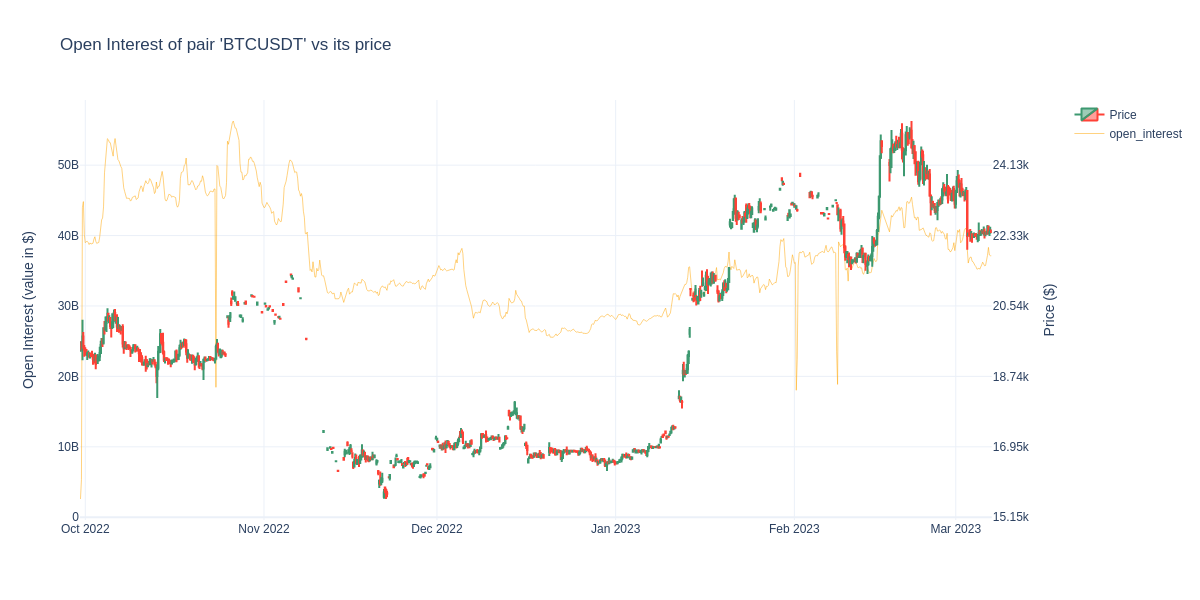

In [14]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

candlestick = go.Candlestick(
    x=tohlcv_resp['time'],
    open=tohlcv_resp['open'],
    high=tohlcv_resp['high'],
    low=tohlcv_resp['low'],
    close=tohlcv_resp['close'],
    name="Price"
)

open_interest = go.Scatter(x=response['time'],
                           y=response['open_interest_value'],
                           name="open_interest",
                           mode='lines',
                           line=dict(width=0.5, color='orange'),
                           )

fig.add_trace(candlestick, secondary_y=True)
fig.add_trace(open_interest, secondary_y=False)

fig.update_layout(
    width=1200, height=600,
    title="Open Interest of pair '{pair}' vs its price".format(pair=pair["symbol"][0]),
    xaxis_rangeslider_visible=False,
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        title="Open Interest (value in $)",
        tickmode="sync",
    ),
    yaxis2=dict(
        title="Price ($)",
        anchor="x",
        overlaying="y",
        side="right",
        tickmode="sync",
    ),
    template = "plotly_white"
)

# Set y-axes titles
fig.update_yaxes(title_text="Open Interest (value in $)", secondary_y=False)
fig.update_yaxes(title_text="Price ($)", secondary_y=True)

fig.show("png")